In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import datetime
from time import time


import seaborn as sns
sns.set(style='ticks')
sns.set_context("notebook", font_scale=1)
sns.set_style("darkgrid")


import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import date

%matplotlib inline

# Import supplementary visualization code visuals.py
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from random import *

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import itertools

#### Load Finalized features

In [2]:
ml_features = pd.read_csv("./features/medicine_finalized_features.csv")

In [3]:
ml_features.shape

(4940, 9205)

In [4]:
ml_features.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
00002034603,4940.0,0.000202,0.014228,0.0,0.0,0.0,0.0,1.0
00002036302,4940.0,0.000405,0.020119,0.0,0.0,0.0,0.0,1.0
00002036303,4940.0,0.000405,0.020119,0.0,0.0,0.0,0.0,1.0
00002036333,4940.0,0.006680,0.103374,0.0,0.0,0.0,0.0,5.0
00002036343,4940.0,0.000607,0.031812,0.0,0.0,0.0,0.0,2.0


#### Normalize the features

With feature sets we have, there may not be a much benefit of normalizaiton. But, training will be a little faster with lower variation of data in input features.

In [5]:
ml_features.head(2)

,PatientGuid,00002034603,00002036302,00002036303,00002036333,00002036343,00002080302,00002080303,00002109402,00002109502,...,Zymar_(gatifloxacin_ophthalmic)_ophthalmic_solution-0.3%,"ZyrTEC-D_(cetirizine-pseudoephedrine)_oral_tablet,_extended_release-5 mg-120 mg","ZyrTEC_(cetirizine)_oral_tablet,_chewable-10 mg",ZyrTEC_(cetirizine)_oral_tablet-10 mg,ZyrTEC_Hives_(cetirizine)_oral_tablet-10 mg,Zyvox_(linezolid)_oral_tablet-600 mg,alli_(orlistat)_oral_capsule-60 mg,depo-subQ_provera_104_(medroxyPROGESTERone)_subcutaneous_suspension-104 mg/0.65 mL,optive_(ocular_lubricant)_ophthalmic_solution--,acid_reflux_patient
0,00033D2D-D57C-48A7-B201-F9183F6E640B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,00044CC1-7911-4C35-B73C-B5623FA3A60F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
columns_to_normalize = ml_features.iloc[:,1:].columns.tolist()
columns_to_normalize.remove('acid_reflux_patient')

In [7]:
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
processed_features = ml_features.copy()
processed_features[columns_to_normalize] = scaler.fit_transform(ml_features[columns_to_normalize])
processed_features.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
00002034603,4940.0,0.000202,0.014228,0.0,0.0,0.0,0.0,1.0
00002036302,4940.0,0.000405,0.020119,0.0,0.0,0.0,0.0,1.0
00002036303,4940.0,0.000405,0.020119,0.0,0.0,0.0,0.0,1.0
00002036333,4940.0,0.006680,0.103374,0.0,0.0,0.0,0.0,5.0
00002036343,4940.0,0.000607,0.031812,0.0,0.0,0.0,0.0,2.0


#### Split into Train and Test Models

In [8]:
from sklearn.cross_validation import train_test_split
features = processed_features.drop(['PatientGuid','acid_reflux_patient'],axis=1)
print (features.shape)
targets = processed_features['acid_reflux_patient']
print (targets.shape)
X_train, X_test, y_train, y_test = train_test_split(features,targets,
                                                    stratify=targets, 
                                                    test_size=0.15)


(4940, 9203)
(4940,)


In [9]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(4199, 9203)
(4199,)
(741, 9203)
(741,)


#### Visualize Acid Reflux patients vs Non Acid Reflux patients in training and testing data

In [10]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

Text(0,0.5,'')

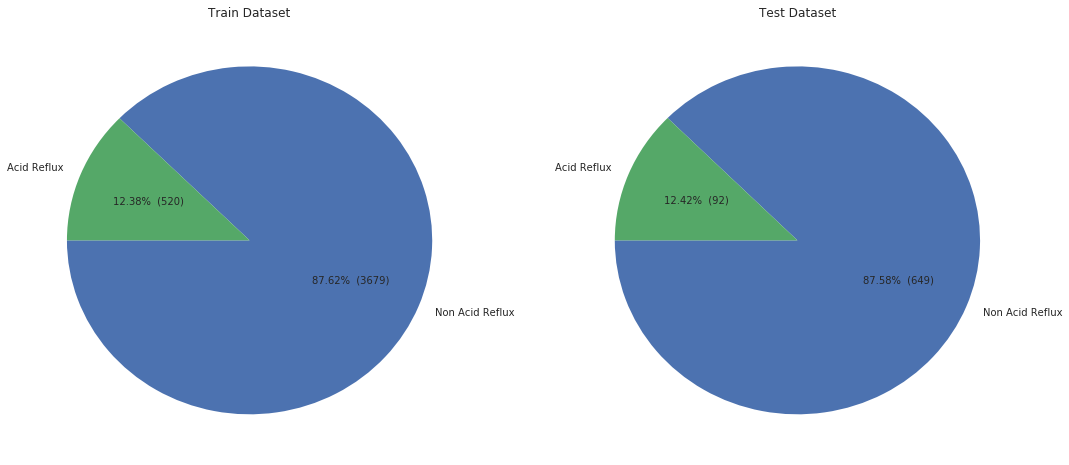

In [11]:
labels = 'Non Acid Reflux','Acid Reflux'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
ax = y_train.value_counts().plot.pie(\
    autopct=make_autopct(y_train.value_counts()),\
    startangle = 180,title='Train Dataset',labels=labels,ax=ax1)
ax.set_ylabel('')
ax = y_test.value_counts().plot.pie(\
    autopct=make_autopct(y_test.value_counts()),\
    startangle = 180,title='Test Dataset',labels=labels,ax=ax2)
ax.set_ylabel('')

__Note: __ If we randomly pick a patient as Acid Reflux patient, there is 12% chance that we will get that right.

#### Running and Testing Machine Learning Models

Using sci-kit learn, following machine learning algorithms were run -
-  Logistic Regression
-  Gradient Boosting Classifier
-  Adaboost Classifier
-  Gaussian Naive Bayes
-  Decision Tree Classifier
-  Stochastic Gradient Descent (SGD) classifier
-  Random Forest Classifier

Given what we know about the features, my guess is that Logistic Regression, Gradient Boosting, Adaboost and Random Forest classifier should do well.

In order to test the model, we will use following matrix -

-  Train and Test Accuracy
-  Precision
-  Recall
-  True Negative Rate

In addition, we will also look at the probability of prediction.


#### Test with Logistic Regression

In [12]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


my_random_state = 42

clf = LogisticRegression(random_state=my_random_state)
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
predict_proba = clf.predict_proba(X_test)

print ("Train accuracy: " + str(accuracy_score(y_train[:300], predictions_train)))
print ("Test accuracy: " + str(accuracy_score(y_test, predictions_test)))

tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

result_data = {'Algorithim': [clf.__class__.__name__], 'test_accuracy': [accuracy_score(y_test, predictions_test)], 'Precision': [round(Precision,2)], 'Recall': [round(Recall,2)],'True Negative Rate':[round(True_Negative_Rate,2)]}
test_results = pd.DataFrame(data=result_data)

Train accuracy: 0.9333333333333333
Test accuracy: 0.8717948717948718
Precision: 46.34%
Recall: 20.65%
True_Negative_Rate: 96.61%


#### Test with Gradient Boosting Classifier

In [13]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


my_random_state = 42

clf = GradientBoostingClassifier(random_state=my_random_state)
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
predict_proba = clf.predict_proba(X_test)

print ("Train accuracy: " + str(accuracy_score(y_train[:300], predictions_train)))
print ("Test accuracy: " + str(accuracy_score(y_test, predictions_test)))

tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

test_results.loc[np.max(test_results.index.values)+1] = [clf.__class__.__name__, accuracy_score(y_test, predictions_test),round(Precision,2), round(Recall,2),round(True_Negative_Rate,2)]



Train accuracy: 0.9266666666666666
Test accuracy: 0.8879892037786775
Precision: 59.57%
Recall: 30.43%
True_Negative_Rate: 97.07%


In [14]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


my_random_state = 42

clf = AdaBoostClassifier(random_state=my_random_state)
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
predict_proba = clf.predict_proba(X_test)

print ("Train accuracy: " + str(accuracy_score(y_train[:300], predictions_train)))
print ("Test accuracy: " + str(accuracy_score(y_test, predictions_test)))

tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

test_results.loc[np.max(test_results.index.values)+1] = [clf.__class__.__name__, accuracy_score(y_test, predictions_test),round(Precision,2), round(Recall,2),round(True_Negative_Rate,2)]



Train accuracy: 0.9033333333333333
Test accuracy: 0.8947368421052632
Precision: 65.22%
Recall: 32.61%
True_Negative_Rate: 97.53%


#### Test with GaussianNB

In [15]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


my_random_state = 42

clf = GaussianNB()
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
predict_proba = clf.predict_proba(X_test)

print ("Train accuracy: " + str(accuracy_score(y_train[:300], predictions_train)))
print ("Test accuracy: " + str(accuracy_score(y_test, predictions_test)))

tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

test_results.loc[np.max(test_results.index.values)+1] = [clf.__class__.__name__, accuracy_score(y_test, predictions_test),round(Precision,2), round(Recall,2),round(True_Negative_Rate,2)]



Train accuracy: 0.79
Test accuracy: 0.6099865047233468
Precision: 12.26%
Recall: 34.78%
True_Negative_Rate: 64.71%


#### Test with Decision Tree Classifier

In [16]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


my_random_state = 42

clf = tree.DecisionTreeClassifier(random_state=my_random_state)
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
predict_proba = clf.predict_proba(X_test)

print ("Train accuracy: " + str(accuracy_score(y_train[:300], predictions_train)))
print ("Test accuracy: " + str(accuracy_score(y_test, predictions_test)))

tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

test_results.loc[np.max(test_results.index.values)+1] = [clf.__class__.__name__, accuracy_score(y_test, predictions_test),round(Precision,2), round(Recall,2),round(True_Negative_Rate,2)]


Train accuracy: 0.9933333333333333
Test accuracy: 0.844804318488529
Precision: 39.45%
Recall: 46.74%
True_Negative_Rate: 89.83%


#### Test with SGD Classifier

In [17]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


my_random_state = 42

clf = SGDClassifier(random_state=my_random_state)
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
#predict_proba = clf.predict_proba(X_test)

print ("Train accuracy: " + str(accuracy_score(y_train[:300], predictions_train)))
print ("Test accuracy: " + str(accuracy_score(y_test, predictions_test)))

tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

test_results.loc[np.max(test_results.index.values)+1] = [clf.__class__.__name__, accuracy_score(y_test, predictions_test),round(Precision,2), round(Recall,2),round(True_Negative_Rate,2)]


Train accuracy: 0.9633333333333334
Test accuracy: 0.863697705802969
Precision: 41.51%
Recall: 23.91%
True_Negative_Rate: 95.22%


#### Testing with Random Forest Classifier

In [18]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


my_random_state = 42

clf = RandomForestClassifier(random_state=my_random_state)
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
predict_proba = clf.predict_proba(X_test)

print ("Train accuracy: " + str(accuracy_score(y_train[:300], predictions_train)))
print ("Test accuracy: " + str(accuracy_score(y_test, predictions_test)))

tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

test_results.loc[np.max(test_results.index.values)+1] = [clf.__class__.__name__, accuracy_score(y_test, predictions_test),round(Precision,2), round(Recall,2),round(True_Negative_Rate,2)]


Train accuracy: 0.9866666666666667
Test accuracy: 0.8717948717948718
Precision: 47.76%
Recall: 34.78%
True_Negative_Rate: 94.61%


In [19]:
test_results.rename(index=str, columns={"Precision": "Test_Accuracy"},inplace=True)
test_results.rename(index=str, columns={"Recall": "Precision"},inplace=True)
test_results.rename(index=str, columns={"True Negative Rate": "Recall"},inplace=True)
test_results.rename(index=str, columns={"test_accuracy": "True_Negative_Rate"},inplace=True)

In [20]:
test_results

,Algorithim,Test_Accuracy,Precision,Recall,True_Negative_Rate
0,LogisticRegression,46.340000,20.65,96.61,0.871795
1,GradientBoostingClassifier,0.887989,59.57,30.43,97.070000
2,AdaBoostClassifier,0.894737,65.22,32.61,97.530000
3,GaussianNB,0.609987,12.26,34.78,64.710000
4,DecisionTreeClassifier,0.844804,39.45,46.74,89.830000
5,SGDClassifier,0.863698,41.51,23.91,95.220000
6,RandomForestClassifier,0.871795,47.76,34.78,94.610000


## Presentation of the results

Comparing results, it appears that Random Forest has most reasonable combination of Accuracy, Precision and Recall score. Let's use Random Forest Classifier to present the results.

In [30]:
### Function to calculate and plot confusion matrix
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.coolwarm,
                          chart_type='Recall'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        if chart_type == 'Recall':
            cm = cm.astype('float')*100 / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized Recall based confusion matrix")
        else:
            cm = cm.astype('float')*100 /cm.sum(axis=0)[np.newaxis, :]
            print("Normalized Precision based confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    #print (cm.shape)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(format(cm[i, j], fmt))+"%" if normalize else format(cm[i, j], fmt),
                 horizontalalignment="center", family='sans-serif', size=16,weight='bold',
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Confusion matrix to show distribution of results

Total_sample_size: 741


Confusion matrix, without normalization


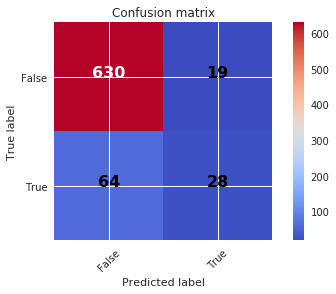

In [31]:
my_random_state = 42

clf = GradientBoostingClassifier(random_state=my_random_state)
learner = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train[:300])
predict_proba = clf.predict_proba(X_test)

cnf_matrix = confusion_matrix(y_test, predictions_test)
np.set_printoptions(precision=2)
plt.figure()
print ("Total_sample_size: " + str(y_test.shape[0]))
print("\n")
plot_confusion_matrix(cnf_matrix, classes=["False", "True"],normalize=False,
                      title='Confusion matrix')

#### Confusion matrix to show Precision of True Positive Results

Precision of True Positive is almost 60%.

Normalized Precision based confusion matrix


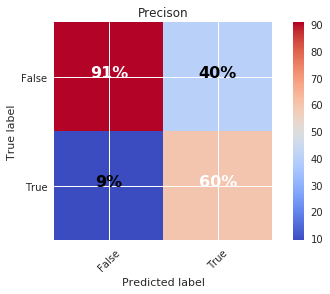

In [32]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["False", "True"],normalize=True,
                      title='Precison',chart_type='Precision' )

#### Confustion Matrix to show recall.

As can be seen in the diagram, Recall is 30%. If we pick a patient randomly to identify an Acid Reflux patient, it's 12% likely that we will get it right. This basic model predicts correctly 30% of time (2.5 times better than random pick up result).

Normalized Recall based confusion matrix


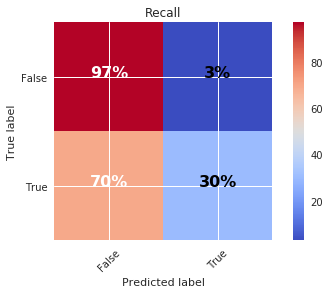

In [33]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["False", "True"],normalize=True,
                      title='Recall')

#### Probability distribution of results

In [34]:
result_set = y_test.to_frame()
result_set.rename(index=str, columns={"acid_reflux_patient": "actual_outcome"},inplace=True)
result_set['predicted_outcome'] = predictions_test
result_set['false_proba'] = predict_proba[:,0]
result_set['true_proba'] = predict_proba[:,1]

In [35]:
def calculate_result_type(row):
    if (row.actual_outcome == 1) & (row.actual_outcome == row.predicted_outcome):
        return "True_Positive"
    elif (row.actual_outcome == 0) & (row.actual_outcome != row.predicted_outcome):
        return "False_Positive"
    elif (row.actual_outcome == 0) & (row.actual_outcome == row.predicted_outcome):
        return "True_Negative"
    elif (row.actual_outcome == 1) & (row.actual_outcome != row.predicted_outcome):
        return "False_Negative"

In [36]:
result_set['LR_Result_Type'] = result_set.apply(calculate_result_type, axis=1)
result_set.head(5)

,actual_outcome,predicted_outcome,false_proba,true_proba,LR_Result_Type
1597,0,0,0.919701,0.080299,True_Negative
2155,0,0,0.919701,0.080299,True_Negative
528,0,0,0.919701,0.080299,True_Negative
654,1,0,0.919701,0.080299,False_Negative
4330,1,0,0.775903,0.224097,False_Negative


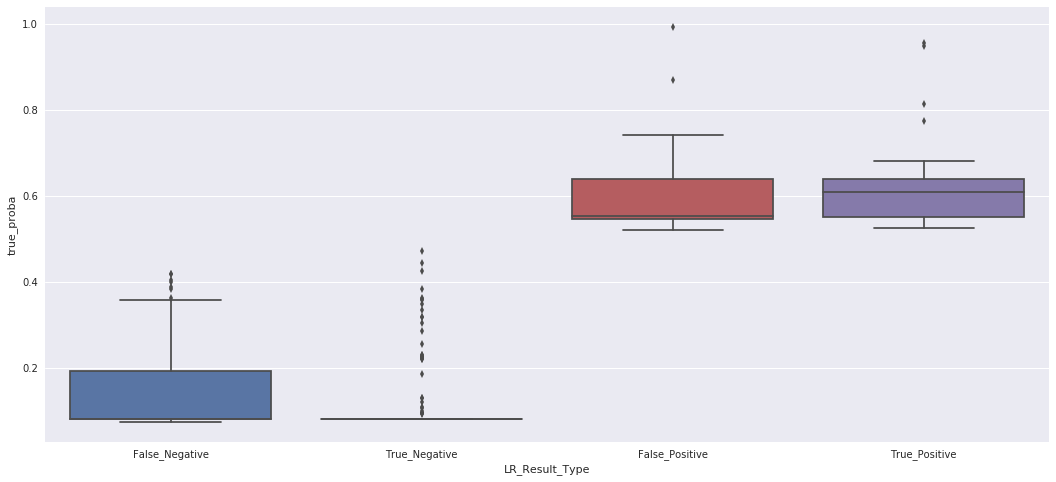

In [37]:
#result_set.sort_values(['true_proba'],inplace=True)
fig, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(18,8))
sns.boxplot(y="true_proba",x="LR_Result_Type", data=result_set.sort_values(by=["true_proba"]),ax=ax1)

___Probabilty distribution gives the good way to identify patients who are most likely to have Acid Reflux. True positive has the probability on the higher side.___

## Feature importance

Let's look at 20 most important features now.

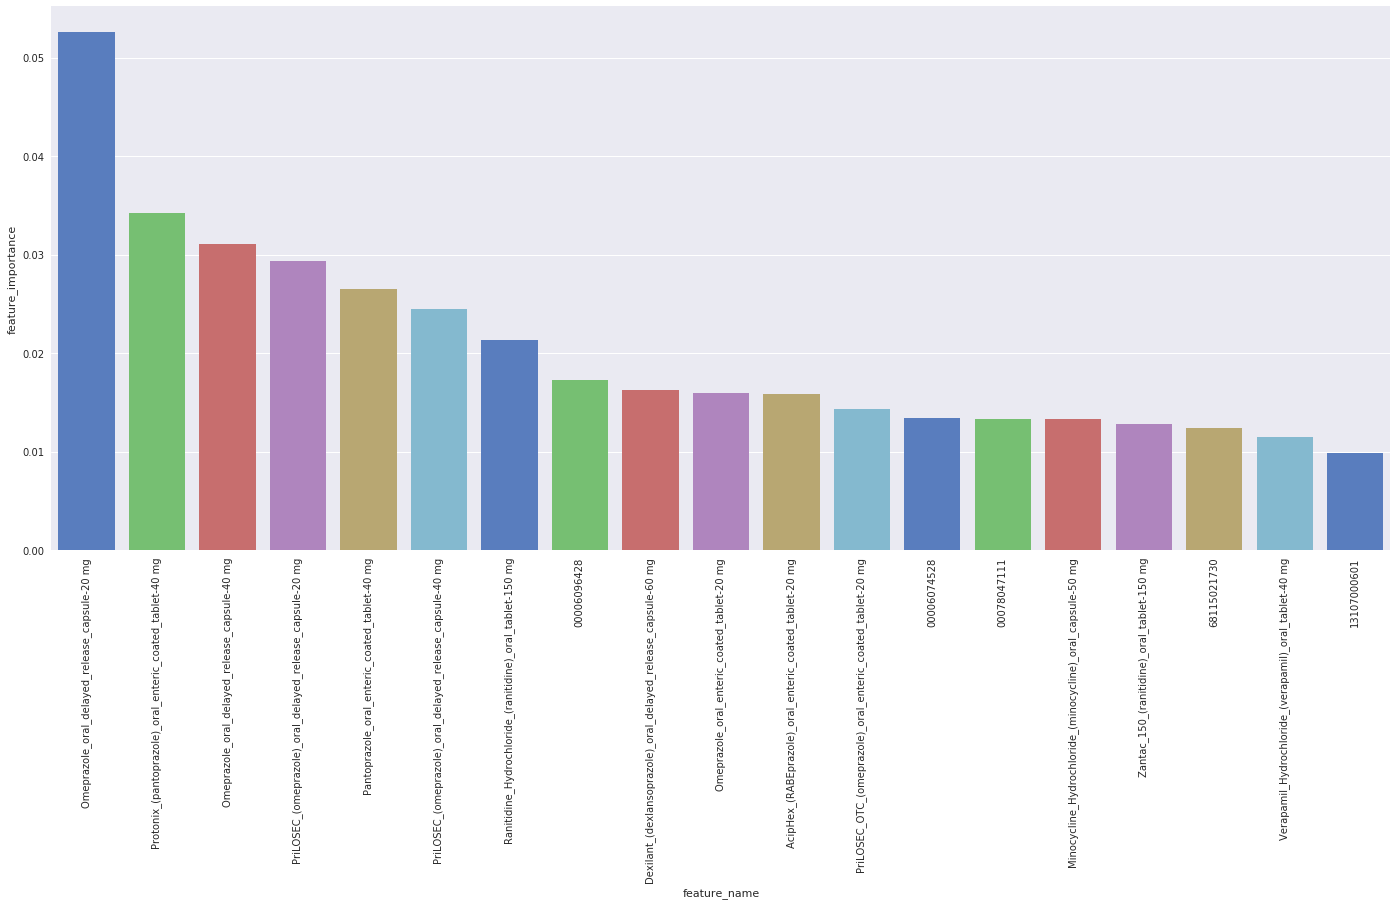

In [38]:
feature_importance_df = pd.DataFrame({'feature_name': features.columns, 'feature_importance': clf.feature_importances_})
feature_importance_df.sort_values(['feature_importance'],ascending=False,inplace=True)

fig,ax1 = plt.subplots(1, 1,figsize=(24,10),gridspec_kw={'hspace':0.4})

g = sns.barplot(x="feature_name",y="feature_importance",data=feature_importance_df.iloc[1:20],ax=ax1,palette="muted")
for item in g.get_xticklabels():
    item.set_rotation(90)

As can be seen, top 20 features are either NDC Code or Medicine Name. We will have to look into more details on each of the items to understand more.